In [87]:
# from gwpopulation.models.redshift import PowerLawRedshift
from bilby.core.result import read_in_result
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import deepdish as dd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import h5py
import requests
import math

In [2]:
# reading in data
mass_PDB_path = 'O1O2O3all_mass_h_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(mass_PDB_path, 'r') as _data:
        _data = dd.io.load(mass_PDB_path)
        print(_data.keys())
        print(_data['lines'].keys())

dict_keys(['lines', 'ppd'])
dict_keys(['mass', 'p_mass_1', 'p_mass_2', 'pdf', 'rate_mass_1', 'rate_vs_mass'])


In [3]:
# reading in MGE data4
mass_PDB_path_2 = 'with_230529_mass_h_mass_data.h5'
with open(mass_PDB_path_2, 'r') as _data2:
        _data2 = dd.io.load(mass_PDB_path_2)
        print(_data2.keys())
        print(_data2['lines'].keys())

dict_keys(['lines', 'ppd'])
dict_keys(['mass', 'p_mass_1', 'p_mass_2', 'pdf', 'rate_mass_1', 'rate_vs_mass'])


In [4]:
# load and read file
EOS_file = 'LCEHL_EOS_posterior_samples_PSR+GW+Nicer.h5'
EOS_set = h5py.File(EOS_file, 'r')

# we're going to do a dictionary of data frames
# the data frames contain the columns of eos or ns macroscopic values
# they have nice labels
# the dictionary labels each eos,
  # although they are sequentially numbered
  # which is why we can find them from a range of integers
baseEosSet={}
baseMacroSet={}

for i in range(len(EOS_set['ns'])):
  baseEosSet[i] = pd.DataFrame(np.array(EOS_set['eos']['eos_'+str(i)][:]))
for i in range(len(EOS_set['ns'])):
  baseMacroSet[i] = pd.DataFrame(np.array(EOS_set['ns']['eos_'+str(i)][:]))

# set a maximum mass index for the dictionaries made
maxind = [np.argmax(baseMacroSet[i]['M']) for i in baseEosSet]

In [5]:
# PDB data stores in 1500 x 2000
# each distribution is a row with columns being mass ranging form 1-100 solar mass
# to work with NS masses, I've cut off at 2.5 solar mass for each distribution

# make list of ns masses
c_mass = _data['lines']['mass']
cut_mass = [x for x in c_mass if x <= 2.5]

# array into list
ns_masses = []
for elem in cut_mass:
    for elem2 in elem:
        ns_masses.append(elem2)
          
# define delta m as the differential
# mass[i+1] - mass[i]
# cuts off at maximum index of the masses
y=1
y2=0
delta_m = []
while y<=ns_masses.index(max(ns_masses)):
    delta_m.append(ns_masses[y] - ns_masses[y2])
    y+=1
    y2+=1
    

# make list of ns masses for MGE data
c_mass2 = _data2['lines']['mass']
cut_mass2 = [x for x in c_mass2 if x <= 2.5]

# array into list
ns_masses2 = []
for elem2 in cut_mass2:
    for elem22 in elem2:
        ns_masses2.append(elem22)
          
# define delta m as the differential
# mass[i+1] - mass[i]
# cuts off at maximum index of the masses
y_2=1
y2_2=0
delta_m2 = []
while y_2<=ns_masses2.index(max(ns_masses2)):
    delta_m2.append(ns_masses2[y_2] - ns_masses2[y2_2])
    y_2+=1
    y2_2+=1

In [6]:
# make a function to numerically integrate differential merger rate into merger rate
# multiply the dr/dm1 value wtih corresponding delta m 
def integrate_sum(fx):
    Rates_list = []
    for x,y in zip(fx,delta_m):
        value = x * y
        Rates_list.append(value)
    # apply the sum of the products
    sum_int = sum(Rates_list)
    return sum_int

In [7]:
# for MGE
# make a function to numerically integrate differential merger rate into merger rate
# multiply the dr/dm1 value wtih corresponding delta m 
def integrate_sum2(fx):
    Rates_list = []
    for x,y in zip(fx,delta_m2):
        value = x * y
        Rates_list.append(value)
    # apply the sum of the products
    sum_int = sum(Rates_list)
    return sum_int

In [8]:
# numerically integrate for the 1500 rows of dr/dm1
r=0
rates = []
while r<=1499:
    rates.append(integrate_sum(_data['lines']['rate_mass_1'][r]))
    r+=1
    
# convert the units
alt_rates = []
for rate in rates:
    alt_rates.append(rate*0.01)
    
len(alt_rates)

1500

In [9]:
# for MGE
# numerically integrate for the 1500 rows of dr/dm1
r2=0
rates_mge = []
while r2<=1499:
    rates_mge.append(integrate_sum2(_data2['lines']['rate_mass_1'][r2]))
    r2+=1
    
# convert the units
alt_rates_mge = []
for rate in rates_mge:
    alt_rates_mge.append(rate*0.01)
    
len(alt_rates_mge)

1500

In [54]:
# creating dictionaries of each distribution of probabilities of mass
prob_dict_mass1 = {}
prob_dict_mass2 = {}
prob_dict_mass1_mge = {}
prob_dict_mass2_mge = {}

i=0

while i<=1499:
    # probilities for each mass in the row up untill the maximum NS mass chosen(2.5)
    prob_mass1 = []
    for elem in _data['lines']['p_mass_1'][i]:
        prob_mass1.append(elem)
    prob_mass1 = prob_mass1[:ns_masses.index(max(ns_masses))+1]
    prob_dict_mass1[i] = prob_mass1
    
    prob_mass2 = []
    for elem in _data['lines']['p_mass_2'][i]:
        prob_mass2.append(elem)
    prob_mass2 = prob_mass2[:ns_masses.index(max(ns_masses))+1]
    prob_dict_mass2[i] = prob_mass2
    
    
    prob_mass1_mge = []
    for elem in _data2['lines']['p_mass_1'][i]:
        prob_mass1_mge.append(elem)
    prob_mass1_mge = prob_mass1_mge[:ns_masses2.index(max(ns_masses2))+1]
    prob_dict_mass1_mge[i] = prob_mass1_mge
    
    prob_mass2_mge = []
    for elem in _data2['lines']['p_mass_2'][i]:
        prob_mass2_mge.append(elem)
    prob_mass2_mge = prob_mass2_mge[:ns_masses2.index(max(ns_masses2))+1]
    prob_dict_mass2_mge[i] = prob_mass2_mge
    
    i+=1

In [55]:
# create a list of masses that'll be worked with throughought for better comparison between EoSs
list_mass1 = []
list_mass2 = []
list_mass1_mge = []
list_mass2_mge = []

j=0
while j<= 1499:
    # randomly choose a mass based on weighted probabilities
    rand_mass1 = random.choices(ns_masses, weights = prob_dict_mass1[j], cum_weights = None, k=1)
    rand_mass2 = random.choices(ns_masses, weights = prob_dict_mass2[j], cum_weights = None, k=1)
    
    # for MGE
    rand_mass1_mge = random.choices(ns_masses2, weights = prob_dict_mass1_mge[j], cum_weights = None, k=1)
    rand_mass2_mge = random.choices(ns_masses2, weights = prob_dict_mass2_mge[j], cum_weights = None, k=1)
    
    
    # random.choices() returns lis, but will only need the value
    ns_mass1 = rand_mass1[0]
    ns_mass2 = rand_mass2[0]
    
    # for MGE
    ns_mass1_mge = rand_mass1_mge[0]
    ns_mass2_mge = rand_mass2_mge[0]
    
    
    # redefines the mass if mass 2 is greater than mass 1
    if ns_mass1 >= ns_mass2:
        mass_1 = ns_mass1
        mass_2 = ns_mass2
    else:
        mass_2 = ns_mass1
        mass_1 = ns_mass2
        
    list_mass1.append(mass_1)
    list_mass2.append(mass_2)
        
        
    # for MGE
    if ns_mass1_mge >= ns_mass2_mge:
        mass_1_mge = ns_mass1_mge
        mass_2_mge = ns_mass2_mge
    else:
        mass_2_mge = ns_mass1_mge
        mass_1_mge = ns_mass2_mge
        
    list_mass1_mge.append(mass_1_mge)
    list_mass2_mge.append(mass_2_mge)
        
    j+=1

Text(0, 0.5, '$m_{ej}\\ (M_{\\odot})$')

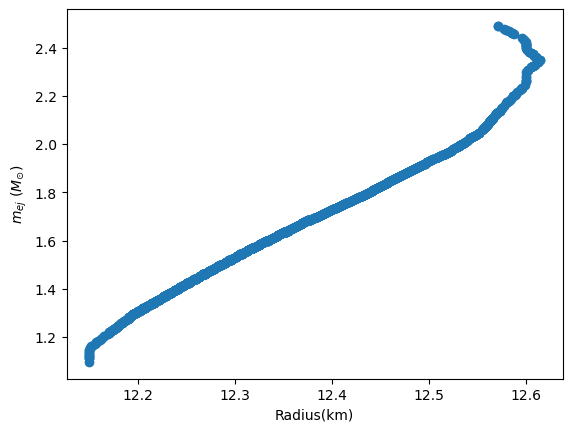

In [56]:
test_key = np.random.choice(range(len(baseMacroSet)))

test_interp_rad = interp1d(baseMacroSet[test_key]['M'][0:maxind[test_key]], baseMacroSet[test_key]['R'][0:maxind[test_key]], fill_value=np.nan, bounds_error = False)

test_rad = test_interp_rad(list_mass1)

plt.scatter(test_rad, list_mass1)
plt.xlabel('Radius(km)')
plt.ylabel('$m_{ej}\ (M_{\\odot})$')

In [57]:
# define constants
c = 2.99792e8

a1 = -8.1324
c1 = 1.4820
d = 1.7784
G = 6.67430e-11

a2 = -9.3335
b = 114.17
c2 = -337.56
n = 1.5465

In [58]:
# obtian ejected mass
M_ej = []

nan_rate_ind = []

for l, (m1, m2) in enumerate(zip(list_mass1, list_mass2)):
    # choose a random Eos  
    key = np.random.choice(range(len(baseMacroSet)))
    
    # interpolate the correspodning radius for each NS
    interp_rad = interp1d(baseMacroSet[key]['M'][0:maxind[key]], baseMacroSet[key]['R'][0:maxind[key]], fill_value=np.nan, bounds_error = False)
    
    Rad_atM1 = interp_rad(m1)
    Rad_atM2 = interp_rad(m2)


    if np.isnan(Rad_atM1) or np.isnan(Rad_atM2):
        nan_rate_ind.append(l)
        continue
    else:
        # calculation for the compactness of each NS
        Comp_1 = (G * ((m2)*(1.989e30))) / (((Rad_atM1)*(1e3)) * (c**2))
        Comp_2 = (G * ((m1)*(1.989e30))) / (((Rad_atM1)*(1e3)) * (c**2))
    
    
        # calculate disk mass
        M_disk = ((a1*Comp_1) + c1)**d
    
    
        # making variables for each term in formula of ejected mass for less room of error
        term_1 = a2/Comp_1
        term_2 = b*((m1**n)/(m2**n))
        term_3 = c2*Comp_1
        term2_1 = a2/Comp_2
        term2_2 = b*((m2**n)/(m1**n))
        term2_3 = c2*Comp_2
    
        # formula for dynamical mass
        mdyn_form = (((term_1 + term_2 + term_3)*m2) + ((term2_1 + term2_2 + term2_3)*m1))
        Mdyn = mdyn_form * (1e-3)
    
    
        # a_dyn for uncertainty in disk mass [0.5,1.5]
        # f_loss for the uncertainty in the physics of the postmerger remnant [0.15,1.0]
        a_dyn = random.uniform(0.5,1.5)
        f_loss = random.uniform(0.15,1.0)
    
    
        # calculate the ejected mass
        Mej = (a_dyn * Mdyn) + (f_loss * M_disk)
        M_ej.append(Mej)

/tmp/ipykernel_824550/303358105.py:27: RuntimeWarning: invalid value encountered in scalar power
  M_disk = ((a1*Comp_1) + c1)**d


In [59]:
# obtian ejected mass
M_ej_mge = []

mge_nan_rate_ind = []

for k, (m1_mge, m2_mge) in enumerate(zip(list_mass1_mge, list_mass2_mge)):
    # choose a random Eos  
    key = np.random.choice(range(len(baseMacroSet)))
    
    # interpolate the correspodning radius for each NS
    interp_rad = interp1d(baseMacroSet[key]['M'][0:maxind[key]], baseMacroSet[key]['R'][0:maxind[key]], fill_value=np.nan, bounds_error = False)

    Rad_atM1_mge = interp_rad(m1_mge)
    Rad_atM2_mge = interp_rad(m2_mge)
    
    if np.isnan(Rad_atM1_mge) or np.isnan(Rad_atM2_mge):
        mge_nan_rate_ind.append(k)
        continue
    else:
        # calculation for the compactness of each NS
    
        Comp_1_mge = (G * ((m2_mge)*(1.989e30))) / (((Rad_atM2_mge)*(1e3)) * (c**2))
        Comp_2_mge = (G * ((m1_mge)*(1.989e30))) / (((Rad_atM1_mge)*(1e3)) * (c**2))
    
    
        # calculate disk mass
        M_disk_mge = ((a1*Comp_1_mge) + c1)**d
    
    
        # making variables for each term in formula of ejected mass for less room of error
        # formula for dynamical mass
    
    
        # "" for MGE
        term_1_mge = a2/Comp_1_mge
        term_2_mge = b*((m1_mge**n)/(m2_mge**n))
        term_3_mge = c2*Comp_1_mge
        term2_1_mge = a2/Comp_2_mge
        term2_2_mge = b*((m2_mge**n)/(m1_mge**n))
        term2_3_mge = c2*Comp_2_mge
    
    
        # "" for mge
        mdyn_form_mge = (((term_1_mge + term_2_mge + term_3_mge)*m2_mge) + ((term2_1_mge + term2_2_mge + term2_3_mge)*m1_mge))
        Mdyn_mge = mdyn_form_mge * (1e-3)
    
    
        # a_dyn for uncertainty in disk mass [0.5,1.5]
        # f_loss for the uncertainty in the physics of the postmerger remnant [0.15,1.0]
        a_dyn = random.uniform(0.5,1.5)
        f_loss = random.uniform(0.15,1.0)
    
    
        # calculate the ejected mass
        # for MGE
        Mej_mge = (a_dyn * Mdyn_mge) + (f_loss * M_disk_mge)
        M_ej_mge.append(Mej_mge)

/tmp/ipykernel_824550/3620781207.py:27: RuntimeWarning: invalid value encountered in scalar power
  M_disk_mge = ((a1*Comp_1_mge) + c1)**d


In [60]:
legred_rates = np.delete(alt_rates, nan_rate_ind)
mge_rates = np.delete(alt_rates_mge, mge_nan_rate_ind)

In [61]:
len(M_ej), len(legred_rates), len(M_ej_mge), len(mge_rates)

(1422, 1422, 1351, 1351)

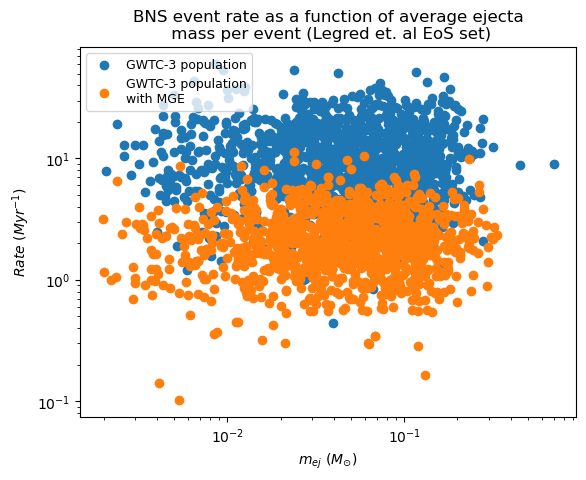

In [62]:
# BNS rate as a function of ejected mass
plt.scatter(M_ej, legred_rates, label = 'GWTC-3 population')
plt.scatter(M_ej_mge, mge_rates, label = 'GWTC-3 population\nwith MGE')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average ejecta\n mass per event (Legred et. al EoS set)')
plt.legend(loc = 'upper left', fontsize = '9')
plt.show()

In [19]:
from os import listdir
from numpy import argmax
# import tov EoS set 
fol_cuter = "cuter_fol"
list_tov_file = listdir(fol_cuter)
list_tov_file = [ll for ll in list_tov_file if ".out" in ll]

# make dictionaries of tov mass and radii
tov_m={}
tov_r={}

jj = 0
for tov in range(len(list_tov_file)):
    findname=f"{fol_cuter}/{list_tov_file[jj]}"
    tov_r[jj],tov_m[jj] = np.loadtxt(findname, usecols = (2,3), unpack = True)
    min_mass = tov_m[jj]>=1.0
    tov_r[jj] = tov_r[jj][min_mass]
    tov_m[jj] = tov_m[jj][min_mass]
    try:
        max_ind = argmax(tov_m[jj])
        tov_r[jj] = tov_r[jj][:max_ind] 
        tov_m[jj] = tov_m[jj][:max_ind]
    except ValueError:
        pass
    jj+=1

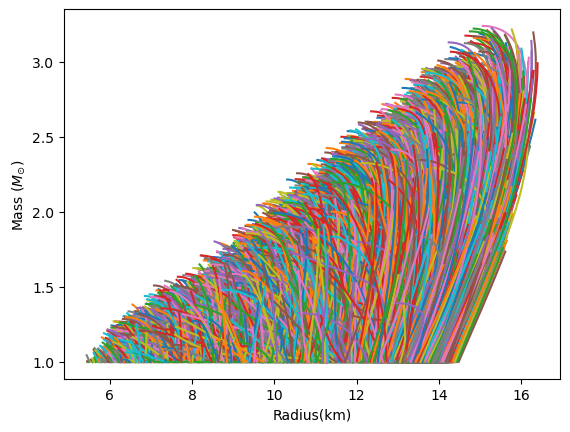

In [20]:
# test plot for EoS set
for i in range(len(list_tov_file)):
    plt.plot(tov_r[i],tov_m[i])
plt.xlabel('Radius(km)')
plt.ylabel('Mass ($M_{\\odot})$')
plt.show()

In [63]:
# obtain ejected mass usinng tov EoS set
tov_M_ej = []
tov_M_ej_mge = []
tov_index = []

for m1, m2, m1_mge, m2_mge in zip(list_mass1, list_mass2, list_mass1_mge, list_mass2_mge):
    # safeguard when interpolating
    while True:
        try:
            # choose a random Eos    
            key = np.random.choice(range(len(tov_r)))
    
    
            # safeguard interpolate the correspodning radius for the objects
            Rad_atM1 = np.interp(m1, tov_m[key], tov_r[key])
            Rad_atM2 = np.interp(m2, tov_m[key], tov_r[key])
    
            Rad_atM1_mge = np.interp(m1_mge, tov_m[key], tov_r[key])
            Rad_atM2_mge = np.interp(m2_mge, tov_m[key], tov_r[key])
    
    
            # calculation for the compactness of each object
            Comp_1 = (G * ((m2)*(1.989e30))) / (((Rad_atM2)*(1e3)) * (c**2))
            Comp_2 = (G * ((m1)*(1.989e30))) / (((Rad_atM1)*(1e3)) * (c**2))
    
            Comp_1_mge = (G * ((m2_mge)*(1.989e30))) / (((Rad_atM2_mge)*(1e3)) * (c**2))
            Comp_2_mge = (G * ((m1_mge)*(1.989e30))) / (((Rad_atM1_mge)*(1e3)) * (c**2))
    
    
            # calculate disk mass
            M_disk = ((a1*Comp_1) + c1)**d
    
            M_disk_mge = ((a1*Comp_1_mge) + c1)**d
    
    
            # making variables for each term in formula of ejected mass for less room of error
            term_1 = a2/Comp_1
            term_2 = b*((m1**n)/(m2**n))
            term_3 = c2*Comp_1
            term2_1 = a2/Comp_2
            term2_2 = b*((m2**n)/(m1**n))
            term2_3 = c2*Comp_2
            
            
            # formula for dynamical mass
            mdyn_form = (((term_1 + term_2 + term_3)*m2) + ((term2_1 + term2_2 + term2_3)*m1))
            Mdyn = mdyn_form * (1e-3)
            
            
            # "" for MGE
            term_1_mge = a2/Comp_1_mge
            term_2_mge = b*((m1_mge**n)/(m2_mge**n))
            term_3_mge = c2*Comp_1_mge
            term2_1_mge = a2/Comp_2_mge
            term2_2_mge = b*((m2_mge**n)/(m1_mge**n))
            term2_3_mge = c2*Comp_2_mge
            
            
            # "" for MGE
            mdyn_form_mge = (((term_1_mge + term_2_mge + term_3_mge)*m2_mge) + ((term2_1_mge + term2_2_mge + term2_3_mge)*m1_mge))
            Mdyn_mge = mdyn_form_mge * (1e-3)
    
    
            # a_dyn for uncertainty[0.5,1.5] in disk mass
            # f_loss for the uncertainty[0.15,1.0] in the physics of the postmerger remnant
            a_dyn = random.uniform(0.5,1.5)
            f_loss = random.uniform(0.15,1.0)
    
    
            # calculate the ejected mass
            Mej = (a_dyn * Mdyn) + (f_loss * M_disk)
            tov_M_ej.append(Mej)
            
            Mej_mge = (a_dyn * Mdyn_mge) + (f_loss * M_disk_mge)
            tov_M_ej_mge.append(Mej_mge)
            
            
            # track the EoS being used
            tov_index.append(key)
            break
        except ValueError:
            pass

/tmp/ipykernel_824550/3324126107.py:33: RuntimeWarning: invalid value encountered in scalar power
  M_disk_mge = ((a1*Comp_1_mge) + c1)**d
/tmp/ipykernel_824550/3324126107.py:31: RuntimeWarning: invalid value encountered in scalar power
  M_disk = ((a1*Comp_1) + c1)**d


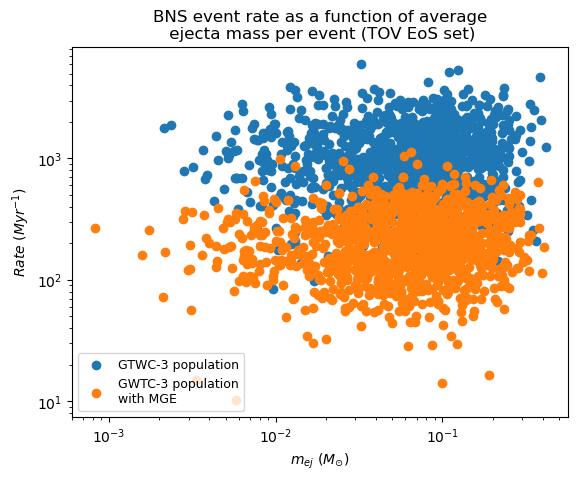

In [64]:
# BNS rate as a function of ejected mass
plt.scatter(tov_M_ej, rates, label = 'GTWC-3 population')
plt.scatter(tov_M_ej_mge, rates_mge, label = 'GWTC-3 population\nwith MGE')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average\n ejecta mass per event (TOV EoS set)')
plt.legend(loc = 'lower left', fontsize = '9')
plt.show()

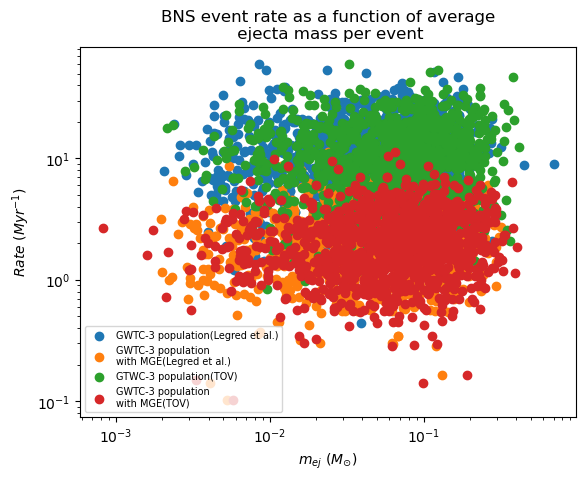

In [104]:
plt.scatter(M_ej, legred_rates, label = 'GWTC-3 population(Legred et al.)')
plt.scatter(M_ej_mge, mge_rates, label = 'GWTC-3 population\nwith MGE(Legred et al.)')
plt.scatter(tov_M_ej, alt_rates, label = 'GTWC-3 population(TOV)')
plt.scatter(tov_M_ej_mge, alt_rates_mge, label = 'GWTC-3 population\nwith MGE(TOV)')
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.title('BNS event rate as a function of average\n ejecta mass per event')
plt.legend(loc = 'lower left', fontsize = '7')
# plt.savefig("ejected_mass.png")
plt.show()

In [81]:
# Find indices of NaN values
legred_indices = np.where(np.isnan(M_ej))[0]
legred_mge_indices = np.where(np.isnan(M_ej_mge))[0]


In [88]:
cleaned_M_ej = [x for x in M_ej if x is not None and not (isinstance(x, float) and math.isnan(x))]
cleaned_M_ej_mge = [x for x in M_ej_mge if x is not None and not (isinstance(x, float) and math.isnan(x))]

In [90]:
clean_legred_rates = np.delete(legred_rates, legred_indices)
clean_mge_rates = np.delete(mge_rates, legred_mge_indices)

In [91]:
len(cleaned_M_ej), len(clean_legred_rates), len(cleaned_M_ej_mge), len(clean_mge_rates)

(1240, 1240, 1120, 1120)

In [160]:
import matplotlib.patches as mpatches

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

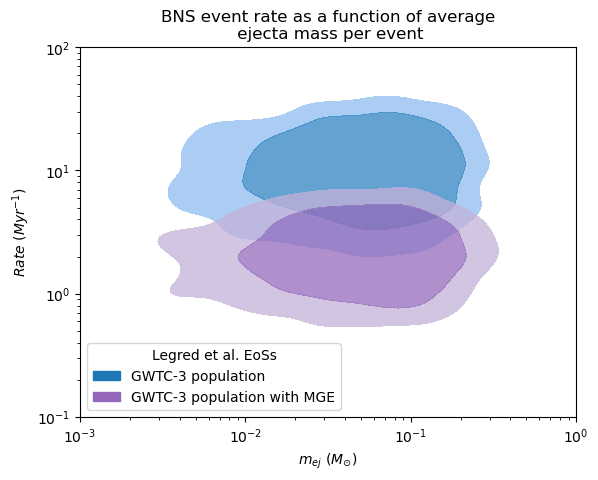

In [178]:
# Create the contour plot using KDE
# Overlay scatter plot
# plt.scatter(x, y, label = 'GWTC-3 population(Legred et al.)')
sns.kdeplot(x = cleaned_M_ej, y = clean_legred_rates, color = 'C0', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
sns.kdeplot(x = cleaned_M_ej_mge, y = clean_mge_rates, color = 'C4', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.xlim(1e-3, 1)
plt.ylim(1e-1, 1e2)
plt.title('BNS event rate as a function of average\n ejecta mass per event')
plt.legend(handles = [mpatches.Patch(color='C0', label='GWTC-3 population'),
                      mpatches.Patch(color="C4", label='GWTC-3 population with MGE')],
           loc = 'lower left', fontsize = '10', title = 'Legred et al. EoSs')
plt.savefig("ejected_mass_legred.png")
plt.show()

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to N

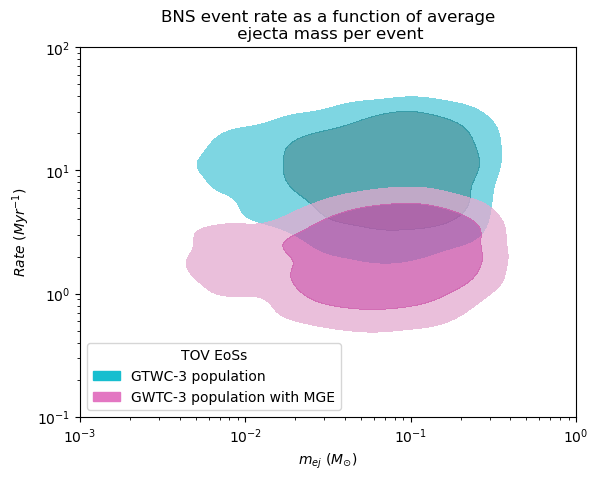

In [179]:
sns.kdeplot(x = tov_M_ej, y = alt_rates,color = 'C9', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
sns.kdeplot(x = tov_M_ej_mge, y = alt_rates_mge, color = 'C6', fill = True, levels = [0.1,0.32,1], log_scale = True, alpha = 0.75)
plt.ylabel('$Rate\ (Myr^{-1})$')
plt.xlabel('$m_{ej}\ (M_{\\odot})$')
plt.yscale('log') 
plt.xscale('log')
plt.xlim(1e-3, 1)
plt.ylim(1e-1, 1e2)
plt.title('BNS event rate as a function of average\n ejecta mass per event')
plt.legend(handles = [mpatches.Patch(color='C9', label='GTWC-3 population'),
                      mpatches.Patch(color="C6", label='GWTC-3 population with MGE')],
           loc = 'lower left', fontsize = '10', title = 'TOV EoSs')
plt.savefig("ejected_mass_tov.png")
plt.show()

In [3]:
# testing chnages for git

In [4]:
# repeat for reassurance in pushing